In [1]:
""" Scratch file for testing code related to preprocessing and augmenting 3D images"""

' Scratch file for testing code related to preprocessing and augmenting 3D images'

# Load Data

In [2]:
import os
import numpy as np;
import matplotlib.pyplot as plt
import torch 
import torchvision.transforms as transforms
import torchio as tio
from utilities.utilities import *

/Users/huayinluo/Documents/code/gapjncsegmentation/gapvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


image (5, 512, 512) (5, 512, 512)
preprocessed image torch.Size([1, 5, 256, 256]) torch.Size([1, 5, 256, 256])


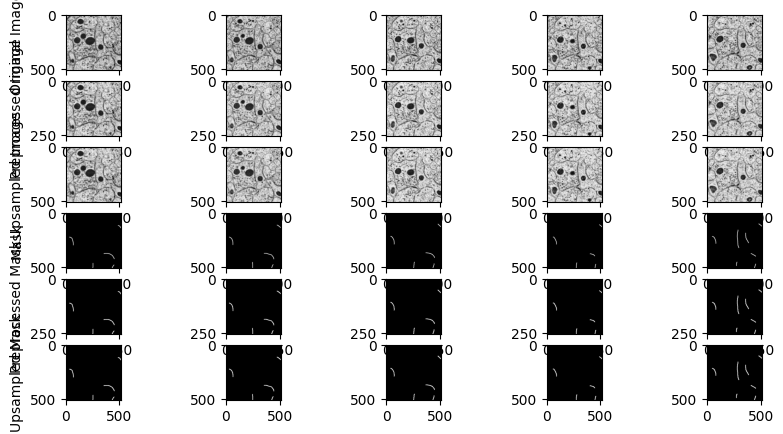

In [10]:
data_dir = "data/tiniest_512"
k = 0
img_path = os.path.join(data_dir, "original", "train", f"{k}.npy")
mask_path = os.path.join(data_dir, "ground_truth", "train", f"{k}.npy")

# original
image = np.load(img_path) # each pixel is 0-255, shape (depth, height, width)
mask = np.load(mask_path) # each pixel is 0 or 1, shape (depth, height, width)
print("image", image.shape, mask.shape)

# preprocess
image_tensor = torch.tensor(image).float().unsqueeze(0) # add channel dimension (depth, height, width) --> (1, depth, height, width)
mask_tensor = torch.tensor(mask).float().unsqueeze(0) # add channel dimension (depth, height, width) --> (1, depth, height, width)
downsample_factor=2
mask_tensor = nn.MaxPool3d((1,downsample_factor,downsample_factor), stride=(1,downsample_factor,downsample_factor))(mask_tensor)
image_tensor = nn.MaxPool3d((1,downsample_factor,downsample_factor), stride=(1,downsample_factor,downsample_factor))(image_tensor)
image_tensor = tio.ZNormalization()(image_tensor)
print("preprocessed image", image_tensor.shape, mask_tensor.shape)

# upsample image tensor from (1,5,256,256) back to (1,5,512,512)
upsampled_image_tensor = nn.Upsample(scale_factor=downsample_factor, mode='nearest')(image_tensor)
upsampled_mask_tensor = nn.Upsample(scale_factor=downsample_factor, mode='nearest')(mask_tensor)

fig, ax = plt.subplots(6, 5, figsize=(10, 5))
visualize_3d_slice(image, ax[0], title="Original Image")
visualize_3d_slice(image_tensor[0], ax[1], title="Preprocessed Image")
visualize_3d_slice(upsampled_image_tensor[0], ax[2], title="Upsampled Image")
visualize_3d_slice(mask, ax[3], title="Mask")
visualize_3d_slice(mask_tensor[0], ax[4], title="Preprocessed Mask")
visualize_3d_slice(upsampled_mask_tensor[0], ax[5], title="Upsampled Mask")
plt.show()

In [4]:
# augment
# Apply the flifp transformation to the subject
subject = tio.Subject(
    image=tio.ScalarImage(tensor=image),
    mask=tio.LabelMap(tensor=mask)
)
flip_transform = tio.RandomFlip(flip_probability=1)
flipped_subject = flip_transform(subject)
image = flipped_subject.image.tensor
mask = flipped_subject.mask.tensor

# Define additional transformations for the image
additional_transforms = tio.Compose([
    tio.RandomBlur(p=0.5),
    tio.RandomNoise(p=0.5),
    tio.RandomGamma(p=0.5)
])

# Apply the additional transformations to the flipped image
image = additional_transforms(image)
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
visualize_3d_slice(image[0], ax[0], title="Original Image")
visualize_3d_slice(mask[0], ax[1], title="Mask")
plt.show()
print(image.shape, mask.shape)

ValueError: Input tensor must be 4D, but it is 3D

In [19]:
# one-hot encode the mask (depth, height, width) --> (depth, height, width, num_classes=2)
one_hot_mask = torch.nn.functional.one_hot(mask.squeeze(0).long(), num_classes=2)
one_hot_mask = one_hot_mask.permute(3, 0, 1, 2).float() # (num_classes, depth, height, width)
print(one_hot_mask.shape)

torch.Size([2, 5, 512, 512])
